# Autoencode(unsupervised learning)

编码器(encoder)——特征集——解码器(decoder)  
学习目标：Autoencoder 的输出尽可能接近输入

应用：  
数据降维：类似于主成分分析（PCA），可以将高维数据映射到低维空间，同时保留主要特征。  
特征提取：提取输入数据的特征，用于后续的分类或聚类任务。  
去噪（Denoising Autoencoder）：学习在噪声数据中提取干净的特征，重构出无噪声的输入。  
生成模型（Variational Autoencoder, VAE）：用于生成新数据样本，例如图像生成。  
异常检测：学习正常数据分布，通过重构误差检测异常数据  

工作流程：  
输入数据：把原始数据作为输入，例如图像、声音、文本等。  
编码阶段：数据通过编码器被压缩成一个低维的潜在表示。  
解码阶段：从潜在表示重构数据。  
优化损失函数：损失函数衡量输入与输出之间的差异，并通过反向传播优化网络参数。

torch.Size([60000, 28, 28])
torch.Size([60000])


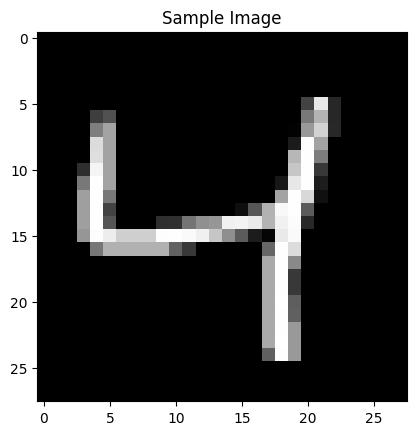

In [8]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

EPOCH = 10
BATCH_SIZE = 64
LR = 0.005
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

###已更新为现代写法
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST
)

print(train_data.data.size())#data：用于访问图像数据
print(train_data.targets.size())#targets：用于访问标签
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title("Sample Image")
plt.show()


In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12,3)
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()#将输出限制在0-1之间
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


可以压缩的原因(Linear)：将高维数据通过矩阵乘法映射到一个低维空间，同时保留主要的特征信息  
通过y=Wx+b —— x (batchsize,784) \ W (128,784) \ b (128) \ y (batchsize,128)

In [14]:
autoencoder = Autoencoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

print(x.shape)

#training 过程
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader):#(x, y) 是当前 mini-batch 的数据
        b_x = x.view(-1,28*28)
        b_y = x.view(-1,28*28)
        
        encoded , decoded = autoencoder(b_x)
        
        loss = loss_func(decoded, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 ==0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
torch.Size([32, 1, 28, 28])
Epoch:  0 | train loss: 0.2322
Epoch:  0 | train loss: 0.0701
Epoch:  0 | train loss: 0.0620
Epoch:  0 | train loss: 0.0596
Epoch:  0 | train loss: 0.0533
Epoch:  0 | train loss: 0.0491
Epoch:  0 | train loss: 0.0454
Epoch:  0 | train loss: 0.0454
Epoch:  0 | train loss: 0.0465
Epoch:  0 | train los

x.view(-1,28*28)中-1表示自动推导该维度的大小：  
总元素数量保持不变，比如(64, 1, 28, 28)，总元素数量为64×1×28×28=50176，view(-1, 784)，则第一维 -1 会被自动计算为 64（因为50176÷784=64）

Autoencoder 的目标是重构输入数据 x，而不是预测标签 y,所以有b_y = x.view(-1,28*28)，我们要的是原图像bx与的coded之后的x进行loss函数运算，而不是像分类问题一样需要分辨出这个数字是多少（需要标签y），而原图像就是x.view(-1,28*28)  
也就是其中一个x.view(-1,28*28)作为输入进入了神经网络，另一个留下来进入y中，作为loss函数的计算标准